In [3]:
import torch

In [4]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.resnet import *
from diy_stable_diffusion.augment import *
from diy_stable_diffusion.accel import *

In [5]:
torch.cuda.is_available()

True

In [6]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [7]:
xl,yl='image', 'label'
name='fashion_mnist'
dsd=load_dataset(name)

@inplace
def transformi(b):
    b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) - 0.5 for o in b[xl]]
    
bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
from types import SimpleNamespace

In [9]:
def linear_sched(betamin=0.0001, betamax=0.02, n_steps=1000):
    beta=torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sigma=beta.sqrt())

In [10]:
# meant only for cosine scheduler?
def abar(t, T):
    # cos(t/T by pi/2) ^ 2
    return ( (t/T) * (math.pi / 2) ).cos()**2

In [11]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts, n_steps)
    alpha = ab/abar(ts - 1, n_steps)
    return SimpleNamespace(a=alpha, abar=ab, sigma=(1-alpha).sqrt())

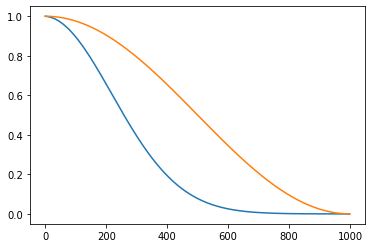

In [12]:
lin_abar= linear_sched().abar
cos_abar= cos_sched().abar
plt.plot(lin_abar)
plt.plot(cos_abar)

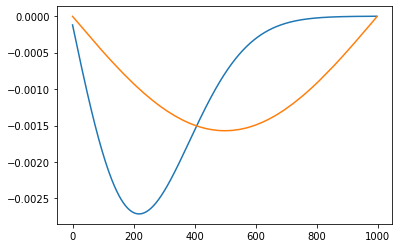

In [13]:
plt.plot(lin_abar[1:] - lin_abar[:-1])
plt.plot(cos_abar[1:] - cos_abar[:-1])

In [14]:
tensor([1,2,3])[tensor([1, 2])][:, None, None, None].shape

torch.Size([2, 1, 1, 1])

In [15]:
m=torch.arange(1,25).reshape(2, 3, 4)
m

tensor([[[ 1,  2,  3,  4],
         [ 5,  6,  7,  8],
         [ 9, 10, 11, 12]],

        [[13, 14, 15, 16],
         [17, 18, 19, 20],
         [21, 22, 23, 24]]])

In [16]:
'''
Want a 'channel' to look like this:
1 5 9
2 6 10
3 7 11
4 8 12

success.
'''
m.permute(0, 2, 1) 

tensor([[[ 1,  5,  9],
         [ 2,  6, 10],
         [ 3,  7, 11],
         [ 4,  8, 12]],

        [[13, 17, 21],
         [14, 18, 22],
         [15, 19, 23],
         [16, 20, 24]]])

In [17]:
'''
should make shape 4,3,2
4 channels of 3x2 grids
but the 4 channels are what used to be the 4 columns
the 3 rows stay the same
the 2 columns are what used to be the two channels

expect:
1, 13
5, 17
9, 21

2, 14
6, 18
10, 22

3, 15
7, 19
11,23 

4, 16
8, 20
12, 24
'''
m.permute(2,1,0)

tensor([[[ 1, 13],
         [ 5, 17],
         [ 9, 21]],

        [[ 2, 14],
         [ 6, 18],
         [10, 22]],

        [[ 3, 15],
         [ 7, 19],
         [11, 23]],

        [[ 4, 16],
         [ 8, 20],
         [12, 24]]])

In [18]:
'''
I think this goes to try to "refill" the 1-24 sequence
into the new shape.

expect

1 2
3 4
5 6

7 8
9 10
11 12

13 14
15 16
17 18

19 20
21 22
23 24


algo for filling (assume three dims):
first read "from" tensor
for i in 0..channels:
 for j in 0..rows:
  for k in 0..cols:
   sequence += from[i][j][k]
   
hence read first the first col of first row of first channel,
then succeed through next cols, then next rows, then next channels

then write "to" tensor

for i in 0..channels:
 for k in 0..rows:
  for k in 0..cols:
   to[i][j][k] = pop(sequence)

'''
m.reshape(4,3,2)

tensor([[[ 1,  2],
         [ 3,  4],
         [ 5,  6]],

        [[ 7,  8],
         [ 9, 10],
         [11, 12]],

        [[13, 14],
         [15, 16],
         [17, 18]],

        [[19, 20],
         [21, 22],
         [23, 24]]])

In [19]:
tensor([1,2,3])[tensor([1, 2])].reshape(-1, 1, 1, 1).shape

torch.Size([2, 1, 1, 1])

In [20]:
n_steps=1000
lin_abar=linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sigma

In [21]:
def noisify(x0, alphabar):
    dev = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,))
    noise = torch.randn(x0.shape, device=dev)
    # equivalent to .reshape(-1, 1, 1, 1)...
    alphabar_t = alphabar[t][:, None, None, None].to(dev)
    ''' alphabar_t is different for each im in batch, this
    multiplication broadcasts a tensor of alphabar for diff-
    erent t-values across the whole batch, one alphabar_t per
    each im '''
    xt = alphabar_t.sqrt()*x0 + (1-alphabar_t).sqrt() * noise
    return (xt, t.to(dev)), noise

In [22]:
xb,_ = next(iter(dls.train))

In [23]:
(xt, t), noise = noisify(xb[:25], alphabar)
t

tensor([ 26, 335, 620, 924, 950, 113, 378,  14, 210, 954, 231, 572, 315, 295,
        567, 706, 749, 876,  73, 111, 899, 213, 541, 769, 287])

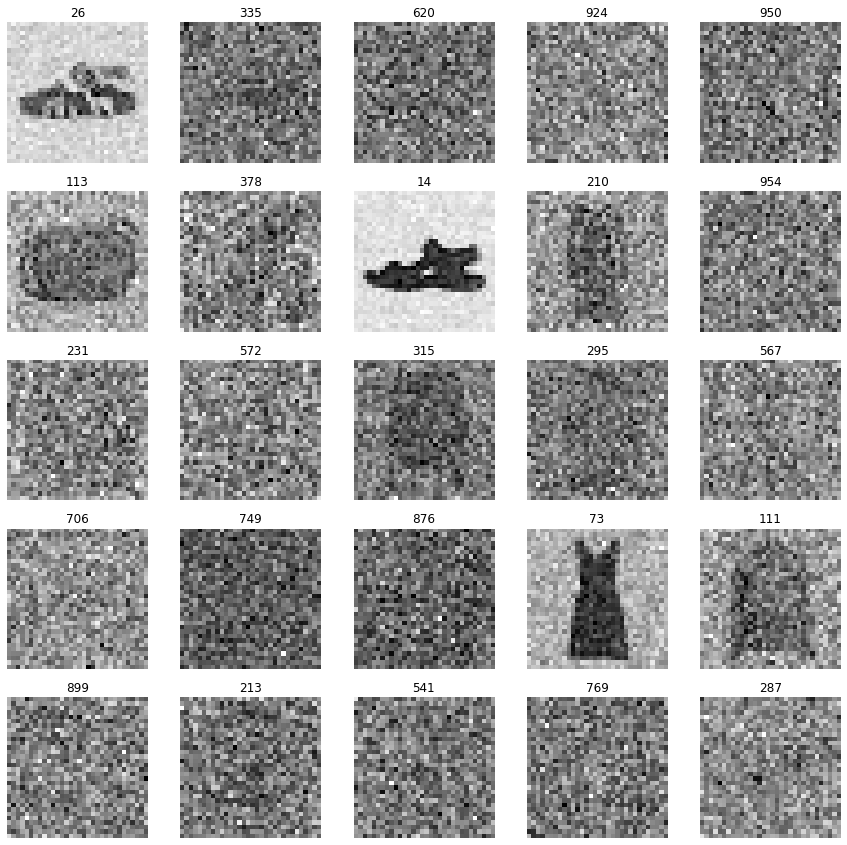

In [24]:
titles=[f'{s}' for s in t]
show_images(xt, titles=titles)

In [25]:
from diffusers import UNet2DModel

# Training DDPM

In [26]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [27]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets or []:
            p.conv2.weight.data.zero_()
            for p in o.downsamplers or []:
                init.orthogonal_(p.conv.weight)
    for o in model.up_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
    
    model.conv_out.weight.data.zero_()

In [28]:
''' default_collate takes a batch in collection/list form
and makes it into a tensor with outer dim = batch size'''
torch.equal(xb,default_collate(list(xb)))

True

In [29]:
bs=350
'''
default_collate by itself would have provided both x and y data in a batch, labeled. We strip away the y-data
for now (don't care about image class / label). We extract from default_collate only the x-data, the image,
and pass that (along with alphabar vector) into noisify so that collate_ddpm returns an "x/y" tuple which is
of the form x=(noised_image, timestep_of_noise), y=added_noise.

It does not hold that x-y = original image. The y noise is combined into x0 according to the formula
xt = alphabar_t.sqrt() * x0 + (1-alphabar_t).sqrt() * added_noise
'''
def collate_ddpm(b):
    return noisify(default_collate(b)[xl], alphabar)

def dl_ddpm(ds, num_workers=4):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm,
                      num_workers=num_workers)

In [30]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [29]:
lr=1e-2
epochs=25
opt_func=partial(optim.AdamW, eps=1e-5)
tmax=epochs*len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs=[DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(),
     BatchSchedCB(sched)]
model=UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn=Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.152,0,train
0.035,0,eval
0.033,1,train
0.032,1,eval
0.029,2,train
0.028,2,eval
0.028,3,train
0.030,3,eval
0.029,4,train
0.028,4,eval


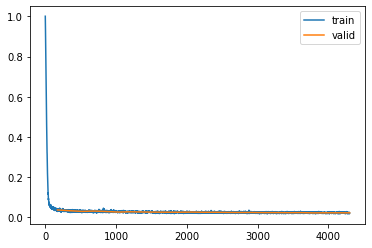

In [32]:
learn.save(epochs)

In [31]:
model_path = Path('models')
model = torch.load(model_path/'2024-01-12-fashion_ddpm3_25_jfshfioa.pkl')

In [34]:
len(list(model.parameters()))

432

In [35]:
@torch.no_grad()
def sample(model, sz):
    dev = next(model.parameters()).device
    xt = torch.randn(sz, device=dev)
    preds = []
    pred_x0s = []
    ab = []
    
    for t in reversed(range(n_steps)):
        t_batch = torch.full((sz[0],), t, device=dev, dtype=torch.long)
        noise = (torch.randn(xt.shape) if t > 0 else torch.zeros(xt.shape)).to(dev)
        alphabar_tmin1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        betabar_t = 1-alphabar[t]
        betabar_tmin1 = 1-alphabar_tmin1
        
        pred_noise = model((xt, t_batch))
        '''
        Given the current information of this step, pred_x0 is what we get from 
        inversing the noise addition function, that is, solving for x0 from this:
        xt = alphabar_t.sqrt()*x0 + (1-alphabar_t).sqrt() * noise
        
        We won't treat this as the actual prediction, we'll treat it as a directional vector
        to move towards (similar to the gradient of parameters being a vector that we multiply
        by a LR to only go partway in that direction) but only go partway, then iterate from
        that point again. In other words we interpolate between xt and pred_x0
        '''
        pred_x0 =  (xt - betabar_t.sqrt() * pred_noise) / alphabar[t].sqrt()
        pred_x0s.append(pred_x0)
        A = alphabar_tmin1.sqrt() * (1-alpha[t]) / betabar_t
        B = alpha[t].sqrt() * betabar_tmin1 / betabar_t
        xt = ( (pred_x0 * A ) + 
               (xt * B) + 
               sigma[t] * noise )
        
        preds.append(xt.float().cpu())
        ab.append((A, B))
    return preds, pred_x0s, ab

In [36]:
s = sample(model, (25, 1, 32, 32))

In [37]:
len(s[0][-25:])

25

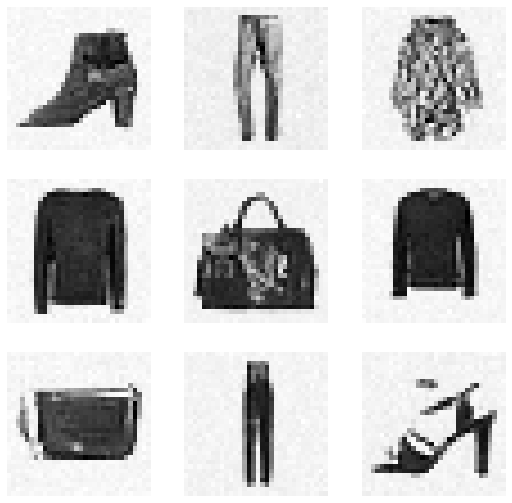

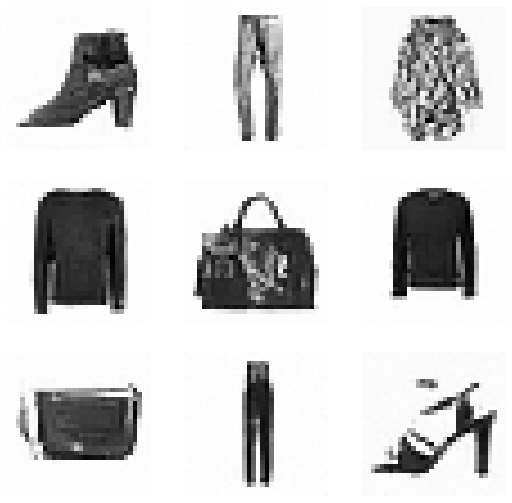

In [41]:
step=950
show_images(s[0][998][:9])
show_images(s[1][998][:9])

## Model 2: no time conditioning

In [36]:
bs=350

In [75]:
def noisify2(x0):
    dev = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), device=dev)
    t=t[:,None,None,None]
    noise = torch.randn(x0.shape, device=dev)
    '''
    just pick uniform weight to balance noise an im, model
    must learn to predict noise without knowing timestep
    but then the noise it predicts should be removed in backward
    process according to timestep
    
    timestep=0, x0=1 and noise=0
    timestep=999, x0=0.001 and noise=0.999
    '''
    xt = ((1000 - t) / 1000) * x0 + t/1000 * noise
    return (xt, torch.zeros((n,), device=dev)), noise

In [67]:
xb,yb=next(iter(dls.train))

In [68]:
xb=xb[:16].cuda()

In [69]:
xb.shape

torch.Size([16, 1, 32, 32])

In [70]:
n=len(xb)
n

16

In [71]:
t=torch.randint(0,n_steps,(n,))
t.shape

torch.Size([16])

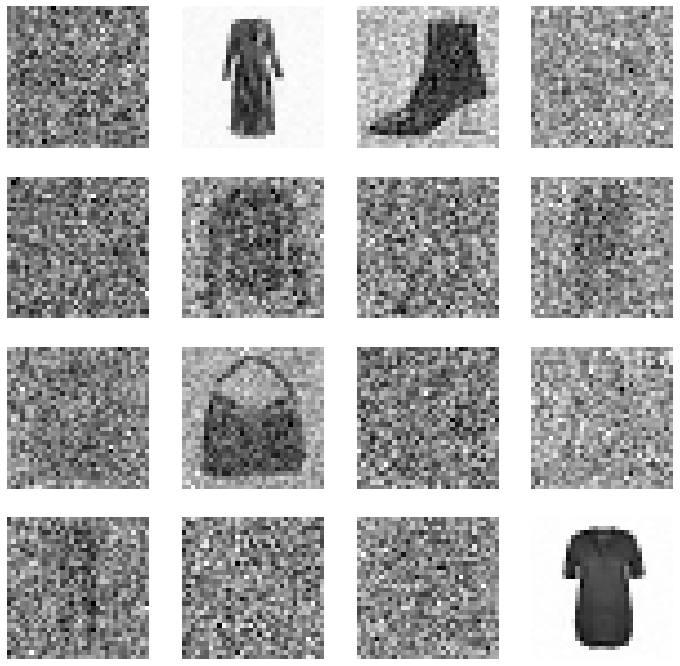

In [78]:
(xt, _), noise = noisify2(xb)
show_images(xt)

In [91]:
bs=350
'''
default_collate by itself would have provided both x and y data in a batch, labeled. We strip away the y-data
for now (don't care about image class / label). We extract from default_collate only the x-data, the image,
and pass that (along with alphabar vector) into noisify so that collate_ddpm returns an "x/y" tuple which is
of the form x=(noised_image, timestep_of_noise), y=added_noise.

It does not hold that x-y = original image. The y noise is combined into x0 according to the formula
xt = alphabar_t.sqrt() * x0 + (1-alphabar_t).sqrt() * added_noise
'''
def collate_ddpm2(b):
    return noisify2(default_collate(b)[xl])

def dl_ddpm2(ds, num_workers=4):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm2,
                      num_workers=num_workers)

In [92]:
dls=DataLoaders(dl_ddpm2(tds['train']), dl_ddpm2(tds['test']))

In [107]:
t=torch.zeros((11,))
    print('yeah')

yeah


torch.Tensor

In [111]:
to_cpu??

Signature: to_cpu(x)
Docstring: <no docstring>
Source:   
def to_cpu(x):
    if isinstance(x, Mapping):
        return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list):
        return [to_cpu(i) for i in x]
    if isinstance(x, tuple):
        return tuple(to_cpu(list(x)))
    
    x = x.detach().cpu()
    
    return x.float() if x.dtype==torch.float16 else x
File:      /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/learner.py
Type:      function


In [118]:
lr=1e-2
epochs=10
opt_func=partial(optim.AdamW, eps=1e-5)
tmax=epochs*len(dls.train)
sched=partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
astats= ActivationStats()
cbs=[astats, DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(),
     BatchSchedCB(sched)]
model=UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn=Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)
model_path=Path('models')
#torch.save(learn.model, model_path/'2024-01-12-linear-noisify-zyjkhgz.pkl')

In [34]:
model_path=Path('models')

#torch.save(model, model_path='2024-01-12-fashion_ddpm3_25_jfshfioa.pkl')

## Plot of x0_coeff and xt_coeff

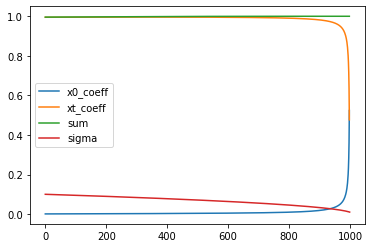

In [163]:
a,b = zip(*s[2])
len(a),len(b)

plt.plot(a[:-1], label='x0_coeff')
plt.plot(b[:-1], label='xt_coeff')
plt.plot([aa ++ bb for aa, bb in zip(a[:-1], b[:-1])], label='sum')
plt.plot(reversed(sigma), label='sigma')
plt.legend()

## below does not work
When I try fun little learning rates to try to interpolate more linearly between the predicted image x0 and current xt, things kind of work for a bit before falling apart. About halfway through, pred_x0 is a noisy but reasonable looking image, but then soon after pred_x0 starts looking completely wrong, all black or all white with a little dot. Notably, all images in batch converge entirely into the same image. This may be related to coupling between the timestep, the model's prediction (which takes timestep as input), and the values derived from alpha/beta/etc that are also based on timestep. The model expects things that, given the timestep, are noised a certain amount, and solving for pred_x0 as a function of the greek parameters is also based on that timestep, hence if I'm not actually winding x_t backward through time according to the "noise schedule" defined by those greek parameters, then xt doesn't agree with t and everything goes haywire.


In [150]:
@torch.no_grad()
def sample_linear_lr(model, sz):
    dev = next(model.parameters()).device
    xt = torch.randn(sz, device=dev)
    preds = []
    pred_x0s = []
    pred_noise = None
    for t in reversed(range(n_steps)):
        t_batch = torch.full((sz[0],), t, device=dev, dtype=torch.long)
        noise = (torch.randn(xt.shape) if t > 0 else torch.zeros(xt.shape)).to(dev)
        alphabar_tmin1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        betabar_t = 1-alphabar[t]
        betabar_tmin1 = 1-alphabar_tmin1
        
        if t % 1 == 0 or pred_noise is None:
            pred_noise = model((xt, t_batch))
            pred_x0 =  (xt - betabar_t.sqrt() * pred_noise) / alphabar[t].sqrt()
            pred_x0s.append(pred_x0)
        '''
        Given the current information of this step, pred_x0 is what we get from 
        inversing the noise addition function, that is, solving for x0 from this:
        xt = alphabar_t.sqrt()*x0 + (1-alphabar_t).sqrt() * noise
        
        We won't treat this as the actual prediction, we'll treat it as a directional vector
        to move towards (similar to the gradient of parameters being a vector that we multiply
        by a LR to only go partway in that direction) but only go partway, then iterate from
        that point again. In other words we interpolate between xt and pred_x0
        '''
        '''
        xt = ( (pred_x0 * alphabar_tmin1.sqrt() * (1-alpha[t]) / betabar_t ) + 
               (xt * alpha[t].sqrt() * betabar_tmin1 / betabar_t) + 
               sigma[t] * noise )
        '''
        if t > 500:
            xt_coeff, x0_coeff,noise_coeff = 0.89, 0.01, 0.1
        else:
            xt_coeff, x0_coeff,noise_coeff = 0.75, 0.24, 0.01
        xt = xt_coeff * xt + x0_coeff * pred_x0 + noise_coeff * noise
        
        preds.append(xt.float().cpu())
    return preds, pred_x0s

In [151]:
s_lin = sample_linear_lr(model, (25, 1, 32, 32))

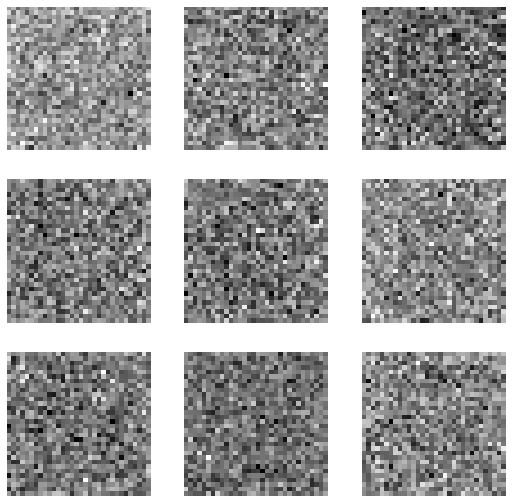

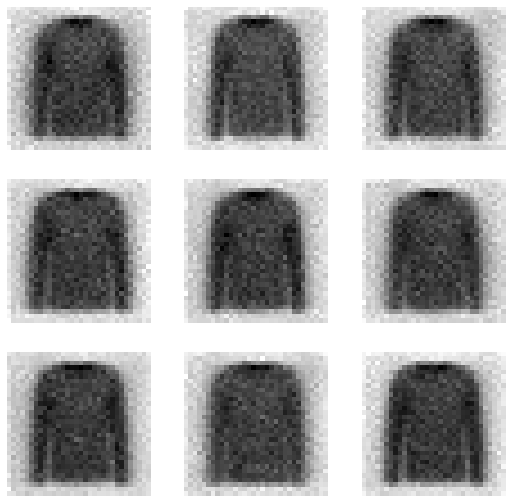

In [160]:
step=400
show_images(s_lin[0][step][:9])
show_images(s_lin[1][step][:9])

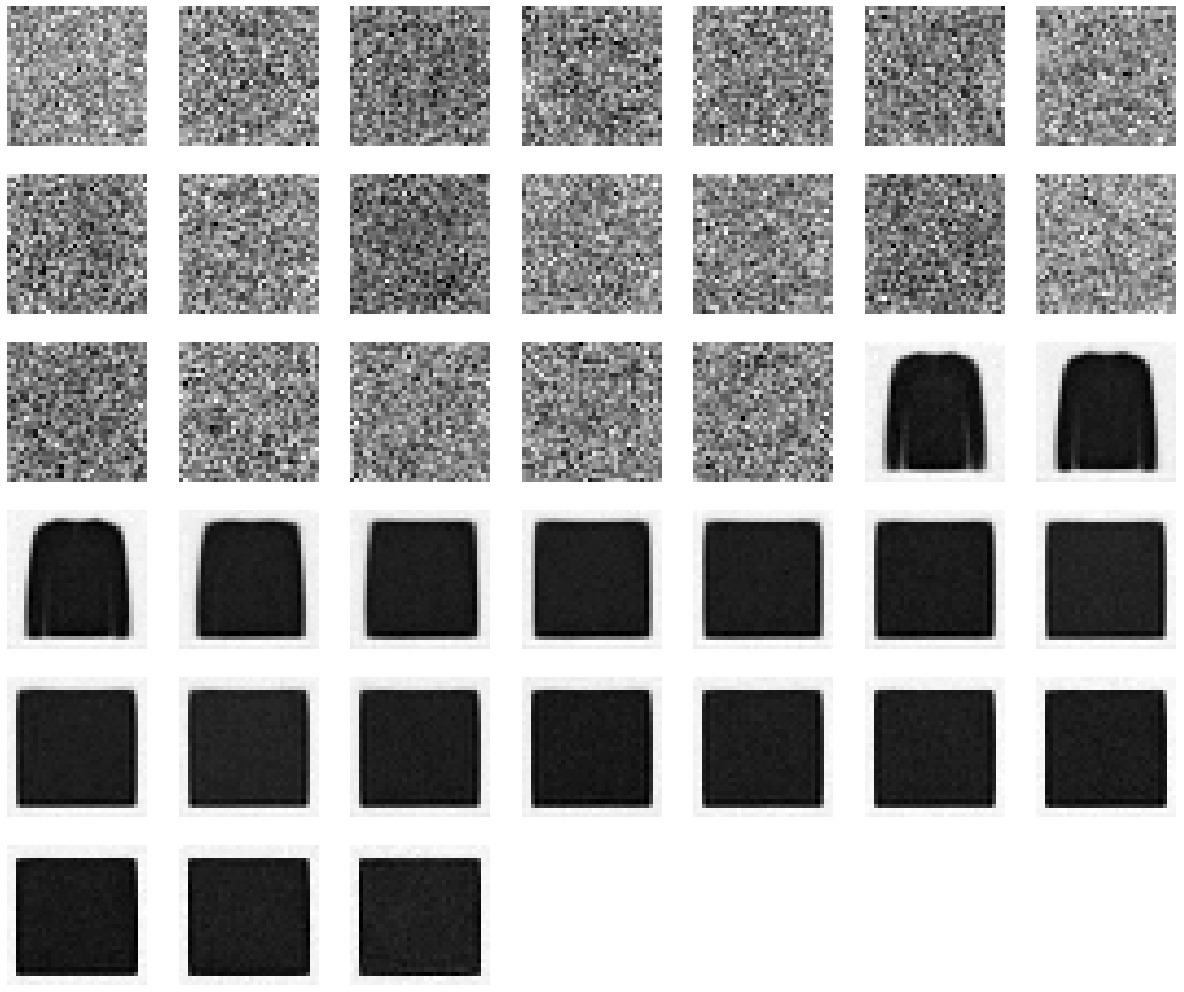

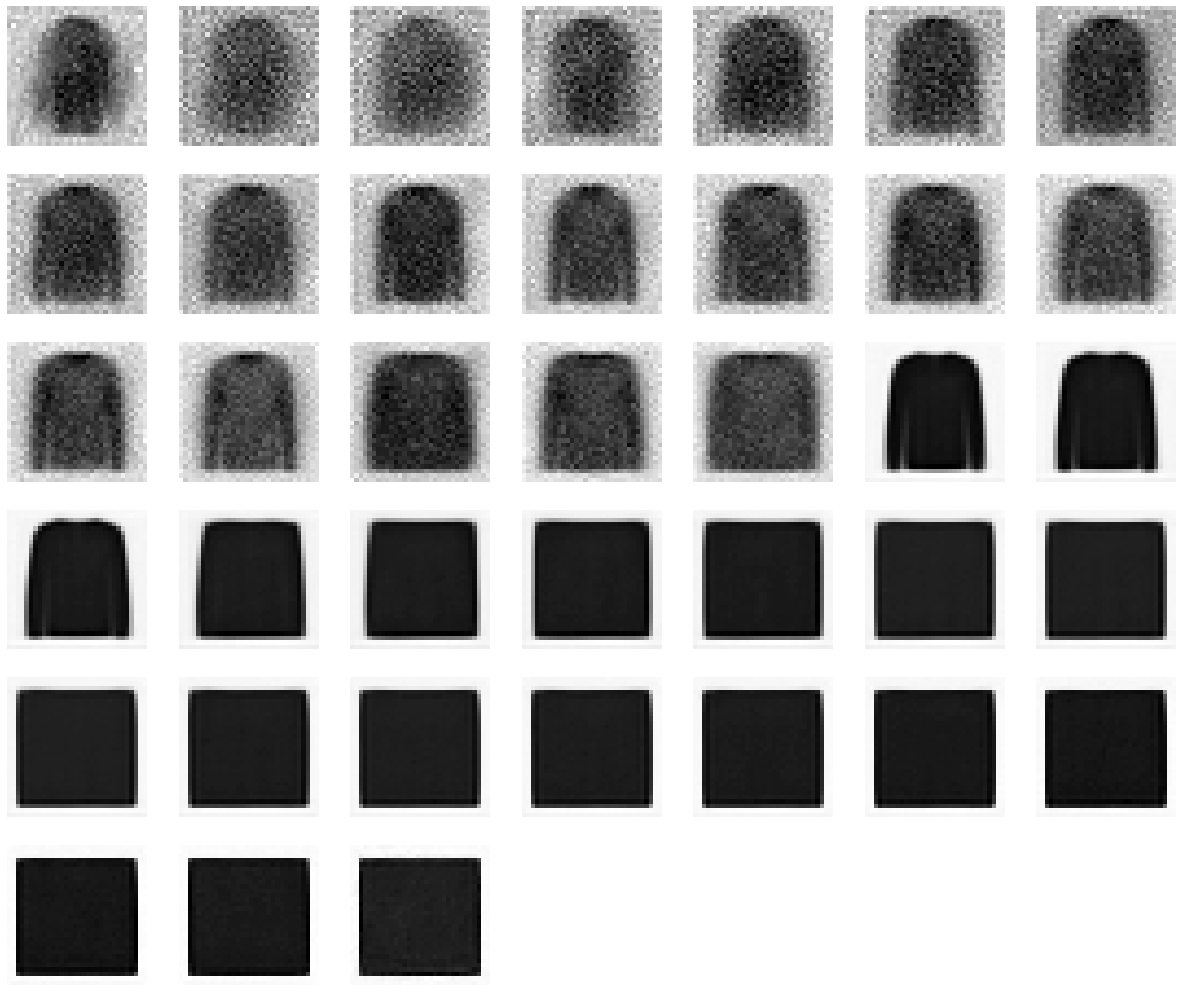

In [157]:
show_images([g[0] for g in s_lin[0][::(1000//36)]])
show_images([g[0] for g in s_lin[1][::(1000//36)]])

# FID

In [43]:
@inplace
def transformi2(b):
    b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) * 2 - 1 for o in b[xl]]

In [74]:
tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)
cmodel = torch.load('models/trytowin2-fmnist-classifier.pkl')

In [48]:
xb,_ = next(iter(dls2.train))
xb.shape

torch.Size([350, 1, 32, 32])

In [65]:
xb=xb.cuda()
cmodel=cmodel.cuda()
preds=cmodel(xb[:4])
preds.shape

torch.Size([4, 10])

In [66]:
preds.argmax(1)

tensor([6, 2, 5, 6], device='cuda:0')

In [71]:
del(cmodel[8])
del(cmodel[7])

In [123]:
!pip install ..

Processing /notebooks/diy-stable-diffusion
  Preparing metadata (setup.py) ... done
  Created wheel for diy-stable-diffusion: filename=diy_stable_diffusion-0.0.1-py3-none-any.whl size=25179 sha256=b265c4c6d67a40c1bdffd536ef3ebe80cf019c963c6ac852b049d0ea614124b8
  Stored in directory: /root/.cache/pip/wheels/44/ea/57/ffb31f1d8d8df22bd19518b55a4093efb82519b26708c5fb7e
Successfully built diy-stable-diffusion
  Attempting uninstall: diy-stable-diffusion
    Found existing installation: diy-stable-diffusion 0.0.1
    Uninstalling diy-stable-diffusion-0.0.1:
      Successfully uninstalled diy-stable-diffusion-0.0.1


In [124]:
import importlib
importlib.reload(diy_stable_diffusion.fid)
importlib.reload(diy_stable_diffusion.augment)
from diy_stable_diffusion.fid import ImageEval

In [125]:
learn.summary??

Signature: learn.summary()
Docstring: <no docstring>
Source:   
@fc.patch
def summary(self:Learner):
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp,totf = 0,0
    def _f(hook, mod, inp, outp):
        nonlocal res,totp,totf
        nparms = sum(o.numel() for o in mod.parameters())
        totp += nparms
        *_,h,w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, do_train=False, do_validate=True, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)
File:      /usr/local/lib/python3.9/dist-packages/diy_stable_diffusion/augment.py
Type:      method


# Skip sampling

In [31]:
@torch.no_grad()
def sample_skip(model, sz):
    dev = next(model.parameters()).device
    xt = torch.randn(sz, device=dev)
    preds = []
    pred_x0s = []
    ab = []
    
    for t in reversed(range(n_steps)):
        t_batch = torch.full((sz[0],), t, device=dev, dtype=torch.long)
        noise = (torch.randn(xt.shape) if t > 0 else torch.zeros(xt.shape)).to(dev)
        alphabar_tmin1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        betabar_t = 1-alphabar[t]
        betabar_tmin1 = 1-alphabar_tmin1
        
        if t % 3 == 0 or t < 50:
            pred_noise = model((xt, t_batch))
        '''
        Given the current information of this step, pred_x0 is what we get from 
        inversing the noise addition function, that is, solving for x0 from this:
        xt = alphabar_t.sqrt()*x0 + (1-alphabar_t).sqrt() * noise
        
        We won't treat this as the actual prediction, we'll treat it as a directional vector
        to move towards (similar to the gradient of parameters being a vector that we multiply
        by a LR to only go partway in that direction) but only go partway, then iterate from
        that point again. In other words we interpolate between xt and pred_x0
        '''
        pred_x0 =  (xt - betabar_t.sqrt() * pred_noise) / alphabar[t].sqrt()
        pred_x0s.append(pred_x0)
        A = alphabar_tmin1.sqrt() * (1-alpha[t]) / betabar_t
        B = alpha[t].sqrt() * betabar_tmin1 / betabar_t
        xt = ( (pred_x0 * A ) + 
               (xt * B) + 
               sigma[t] * noise )
        
        preds.append(xt.float().cpu())
        ab.append((A, B))
    return preds, pred_x0s, ab

In [32]:
sampling_model = torch.load('models/2024-01-12-fashion_ddpm3_25_jfshfioa.pkl')

In [33]:
%%time
n_samples=512
samples = sample_skip(sampling_model, (n_samples, 1, 32, 32))

CPU times: user 1min 50s, sys: 52 s, total: 2min 42s
Wall time: 2min 42s


In [43]:
last_samples=samples[0][-1]

In [44]:
last_samples.shape, last_samples.min(), last_samples.max(), last_samples.median()


(torch.Size([512, 1, 32, 32]),
 tensor(-0.5341),
 tensor(0.6458),
 tensor(-0.4969))

In [45]:
last_samples=last_samples*2

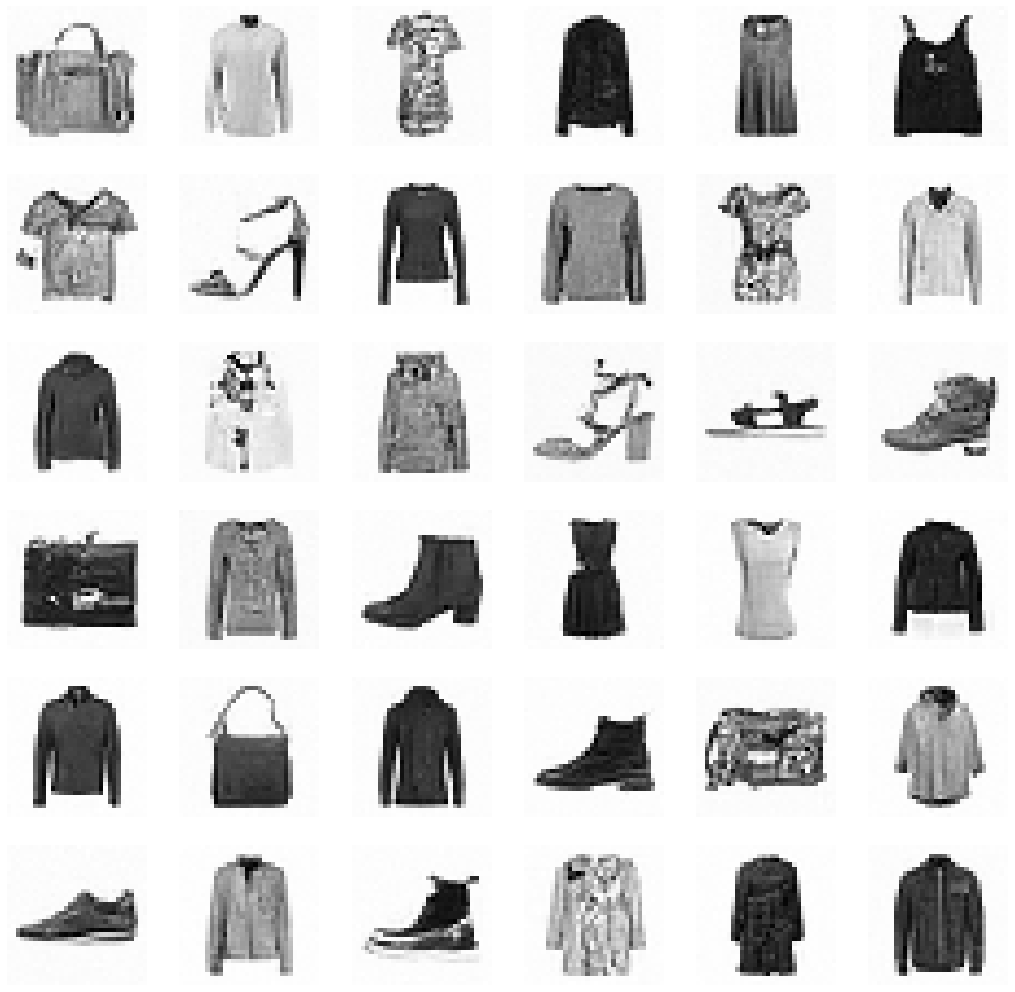

In [46]:
show_images(last_samples[:36])

In [127]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

'''
Create dls2 for two reasons:
- scaling done above, into the range [-1, 1], since TF.to_tensor does range [0,1] by
default
- this dataloader doesn't pack in the timestamp into the xb, but the dls instance
used for training ddpm is a tuple of (tensor_of_images, tensor_of_timestamps). This
works for the "sample" loop because the UNet model is built to take this tuple, and
knows that each image is correlated with the respective timestep in the second tensor
in the tuple, but it doesn't work for the classifier model which just is supposed
to take a tensor.
'''
tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs, num_workers=fc.defaults.cpus)

In [148]:
xb,yb=next(iter(dls.train))

In [149]:
xb[0].shape,xb[1].shape

(torch.Size([350, 1, 32, 32]), torch.Size([350]))

In [150]:
xb[0].min(),xb[0].max(),xb[0].median()

(tensor(-4.4911), tensor(4.2813), tensor(-0.2181))

In [152]:
'''
see the scaling effect on dls2: ims in range [-1, 1]
'''
xb,_ = next(iter(dls2.train))
xb.shape,xb.min(),xb.max(), xb.median()

(torch.Size([350, 1, 32, 32]), tensor(-1.), tensor(1.), tensor(-1.))

In [154]:
last_samples.min(),last_samples.max(),last_samples.median()

(tensor(-1.0681), tensor(1.2916), tensor(-0.9938))

In [132]:
classifier_model = torch.load('../../p2/nbs/models/data_aug2.pkl')
del(classifier_model[8])
del(classifier_model[7])

In [133]:
learn=TrainLearner(classifier_model, dls2, cbs=[DeviceCB()], loss_func=fc.noop, opt_func=None)

In [134]:
learn.capture_preds()[0].shape

torch.Size([10000, 512])

In [135]:
learn.summary()

Tot params: 4902448; MFLOPS: 25.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(350, 1, 32, 32)|(350, 16, 32, 32)|6928|7.0|
|ResBlock|(350, 16, 32, 32)|(350, 32, 16, 16)|14560|3.7|
|ResBlock|(350, 32, 16, 16)|(350, 64, 8, 8)|57792|3.7|
|ResBlock|(350, 64, 8, 8)|(350, 128, 4, 4)|230272|3.7|
|ResBlock|(350, 128, 4, 4)|(350, 256, 2, 2)|919296|3.7|
|ResBlock|(350, 256, 2, 2)|(350, 512, 1, 1)|3673600|3.7|
|Flatten|(350, 512, 1, 1)|(350, 512)|0|0.0|


In [155]:
ie = ImageEval(classifier_model, dls2, cbs=[DeviceCB()])
ie.fid(last_samples),ie.fid(last_samples.clamp(-1.0, 1.0))

(16.250996261378987, 16.64044339537486)

In [163]:
sample_at = [t for t in range(n_steps) if (t+101)%((t+101)//100)==0]
'''
Kind of like, sample every 10, then every 9, every 8, etc.
'''
print(*sample_at, sep='..', end=' - ')

0..1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..101..103..105..107..109..111..113..115..117..119..121..123..125..127..129..131..133..135..137..139..141..143..145..147..149..151..153..155..157..159..161..163..165..167..169..171..173..175..177..179..181..183..185..187..189..191..193..195..197..199..202..205..208..211..214..217..220..223..226..229..232..235..238..241..244..247..250..253..256..259..262..265..268..271..274..277..280..283..286..289..292..295..298..299..303..307..311..315..319..323..327..331..335..339..343..347..351..355..359..363..367..371..375..379..383..387..391..395..399..404..409..414..419..424..429..434..439..444..449..454..459..464..

In [164]:
@torch.no_grad()
def sample2(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    sample_at = {t for t in range(n_steps) if (t+101)%((t+101)//100)==0}
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t in sample_at: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        if t in sample_at: preds.append(x_t.float().cpu())
    return preds

In [165]:
%%time
all_samples = sample2(sampling_model, (n_samples, 1, 32, 32))

CPU times: user 1min 28s, sys: 41 s, total: 2min 9s
Wall time: 2min 9s


In [174]:
final_samples = (all_samples[-1] * 2)
final_samples.min(), final_samples.max(), final_samples.median()

(tensor(-1.0771), tensor(1.2784), tensor(-0.9942))

In [177]:
'''
raw predictions are approximately in range(-0.5, 0.5)

because when I trained the model, I used a dls built on a "tds" (transformed dataset)
that was scaled with a transformer using TF.to_tensor(o) - 0.5, to do that trick 
of keeping a range of 1 but centered at 0.
'''
all_samples[-1].min(),all_samples[-1].max()

(tensor(-0.5386), tensor(0.6392))

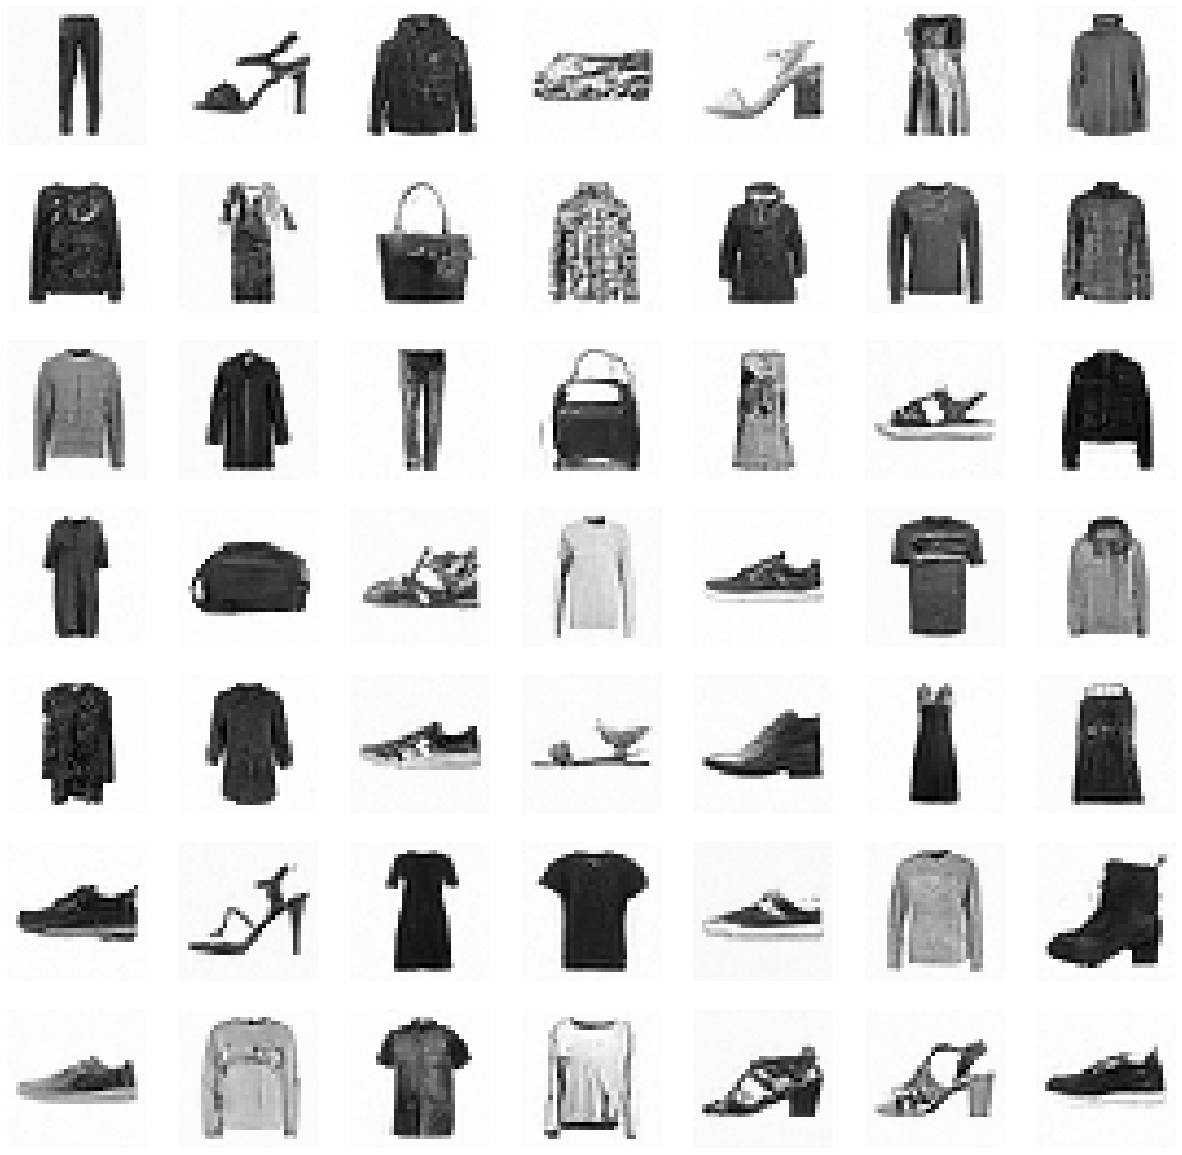

In [178]:
show_images(final_samples[:49])

In [179]:
ie.fid(final_samples)

13.947824561352945